# Parler Unmasked: A Data-Driven Exploration of the Lead-up to January 6, 2021

In [1]:
import pandas as pd
import re
import numpy as np

# Loading the cleaned dataset
file_path = "../../data/cleaned/cleaned_dataset.csv"
cleaned_data = pd.read_csv(file_path)

# Displaying the first few rows of the cleaned dataset
cleaned_data.head()

,author_name,author_username,author_profile_photo,post_text,post_image,post_timestamp,post_impressions
0,Andy Ngo,@AndyNgo,https://images.parler.com/777e039d6a5341388549...,philadelphia police charged in relation to an ...,https://api.parler.com/l/GJCyQ,5,132117.0
1,Bill Kays,@rebootbill,https://images.parler.com/706f1c9d8b454b5f8108...,NaN,NaN,4,13.0
2,Flint Bedrock,@flintbedrock,https://images.parler.com/1f45e69f8ed145f9b7b0...,patriots in dc are ready for tomorrow,NaN,5,248971.0
3,Name Hidden,@Private User,../../company-media.parler.com/par-default-pro...,let s follow each other,https://api.parler.com/l/jB7Lz,5,9829.0
4,Name Hidden,@Private User,../../company-media.parler.com/par-default-pro...,NaN,../../api.parler.com/l/6Ac5M.html,5,15689.0


## Finding the Most Frequent Hashtags

In [2]:
# Function to extract hashtags from text
def extract_hashtags(text):
    return re.findall(r'#\w+', str(text))

# Applying the extract_hashtags function to the post_text column and creating a list of all hashtags
all_hashtags = cleaned_data['post_text'].apply(extract_hashtags).explode().dropna()

# Calculating the frequency of each hashtag
hashtag_counts = all_hashtags.value_counts()

# Displaying the top 20 most common hashtags
top_hashtags = hashtag_counts.head(20)
top_hashtags

post_text
#stopthesteal     11609
#maga             11108
#trump            10214
#electionfraud     5558
#americafirst      5135
#election          5008
#georgia           4066
#kag               3721
#saveamerica       3596
#wwg               3402
#trumptrain        3231
#parler            2901
#voterfraud        2880
#fightback         2824
#marchfortrump     2744
#antifa            2663
#dominion          2480
#donaldtrump       2436
#usa               2414
#covid             2292
Name: count, dtype: int64

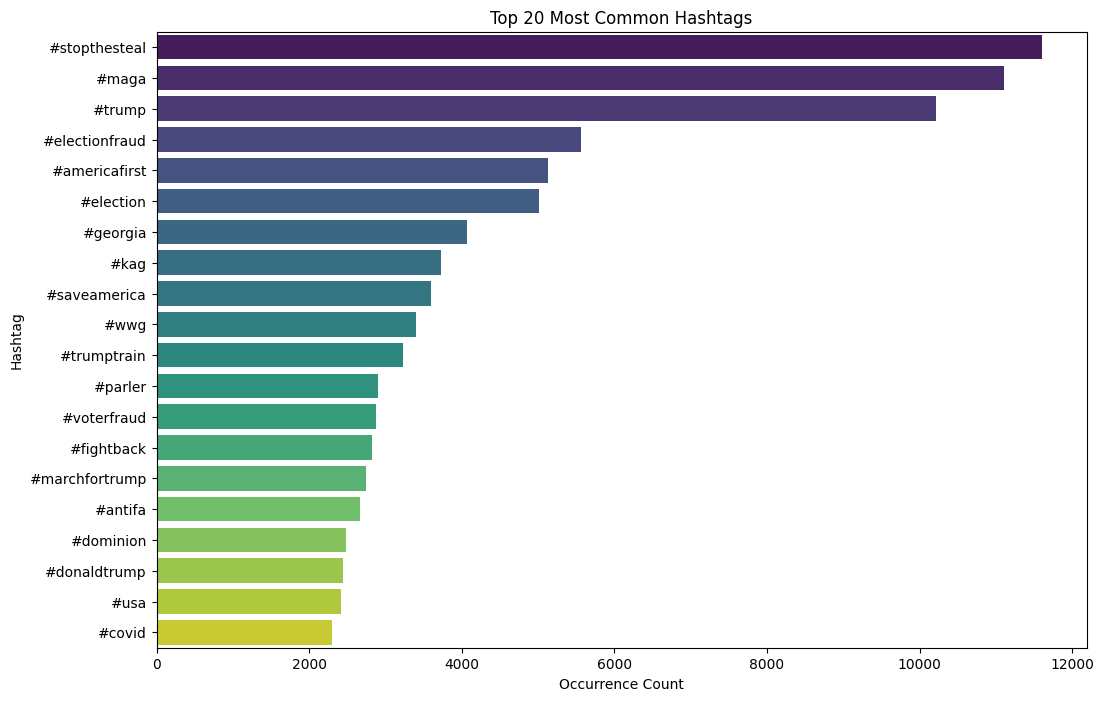

In [3]:
# Importing the Seaborn library
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting the top 20 most common hashtags
top_hashtags = hashtag_counts.head(20)

# Creating a horizontal bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=top_hashtags.values, y=top_hashtags.index, palette='viridis')
plt.title('Top 20 Most Common Hashtags')
plt.xlabel('Occurrence Count')
plt.ylabel('Hashtag')

plt.savefig("../../models/top_hashtags.png")  

plt.show()

## Vectorization (TF-IDF) and Clustering (MiniBatchKMeans)

In [4]:
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

def preprocess_text(text):
    if pd.isnull(text):
        return ''
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w in stop_words]
    return " ".join(filtered_text)

# Apply preprocessing to the post_text column
cleaned_data['post_text'] = cleaned_data['post_text'].apply(preprocess_text)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting to 5000 features
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_data['post_text'])

# Importing MiniBatchKMeans for clustering
from sklearn.cluster import MiniBatchKMeans

# Defining the MiniBatchKMeans model
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=2000)

# Fitting the model to the TF-IDF matrix
minibatch_kmeans.fit(tfidf_matrix)

# Getting the cluster labels for each post
cluster_labels = minibatch_kmeans.labels_

# Adding the cluster labels to the DataFrame
cleaned_data['cluster'] = cluster_labels

# Checking the first few rows to see the cluster labels
cleaned_data.head()

/Users/maggiebreyer/Documents/Education/IronHack/Week_9/Final_project/fin_proj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


,author_name,author_username,author_profile_photo,post_text,post_image,post_timestamp,post_impressions,cluster
0,Andy Ngo,@AndyNgo,https://images.parler.com/777e039d6a5341388549...,philadelphia police charged relation # antifa ...,https://api.parler.com/l/GJCyQ,5,132117.0,4
1,Bill Kays,@rebootbill,https://images.parler.com/706f1c9d8b454b5f8108...,,NaN,4,13.0,8
2,Flint Bedrock,@flintbedrock,https://images.parler.com/1f45e69f8ed145f9b7b0...,patriots dc ready tomorrow,NaN,5,248971.0,5
3,Name Hidden,@Private User,../../company-media.parler.com/par-default-pro...,let follow,https://api.parler.com/l/jB7Lz,5,9829.0,1
4,Name Hidden,@Private User,../../company-media.parler.com/par-default-pro...,,../../api.parler.com/l/6Ac5M.html,5,15689.0,8


In [5]:
cleaned_data.to_csv('../../data/cleaned/clustering_model_one.csv', index=False)

In [6]:
def get_top_terms_per_cluster(tfidf_matrix, cluster_labels, vectorizer, num_terms=10):
    # Get feature names from the TF-IDF vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Create a DataFrame to store the TF-IDF matrix
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray())
    
    # Add the cluster labels to the DataFrame
    df_tfidf['cluster'] = cluster_labels

    # Group by cluster and calculate the mean for each term
    cluster_means = df_tfidf.groupby('cluster').mean()
    
    # Get the top terms for each cluster
    top_terms = {}
    for cluster, row in cluster_means.iterrows():
        top_terms[cluster] = [feature_names[i] for i in row.nlargest(num_terms).index]
    
    return top_terms

# Get the top 10 terms for each cluster
top_terms_per_cluster = get_top_terms_per_cluster(tfidf_matrix, minibatch_kmeans.labels_, tfidf_vectorizer, num_terms=10)

# Print the top terms for each cluster
for cluster, terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")

Cluster 0: votes, explanation, negative, explained, david, taken, georgiathey, perdue, live, still
Cluster 1: let, follow, biden, wtf, us, georgia, live, fraud, see, yes
Cluster 2: people, wow, must, thank, west, wing, hear, right, oval, office
Cluster 3: perdue, vote, votes, georgia, loeffler, warnock, ga, thousand, lead, see
Cluster 4: expecting, holy, cow, america, covid, kamala, harris, king, constitutional, time
Cluster 5: trump, echo, dc, president, follow, patriots, election, watch, georgia, tomorrow
Cluster 6: go, italy, enough, constitution, obama, election, us, politicians, pm, results
Cluster 7: citizen, press, free, plaza, speaking, take, flynn, live, freedom, watch
Cluster 8: biblical, worth, words, starting, maga, thanks, think, bastard, remember, need
Cluster 9: presiding, swear, lt, democratic, session, remove, majority, gov, senator, pennsylvania


In [7]:
import pickle
from scipy.sparse import save_npz

# Save TF-IDF matrix
save_npz('../../models/tfidf_matrix.npz', tfidf_matrix)

# Save TF-IDF vectorizer
with open('../../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

### Inertia, Silhoutte Score, and Elbow Method

In [8]:
import numpy as np
from sklearn.metrics import silhouette_score

# Sample a random subset of the data (e.g., 10%)
sample_indices = np.random.choice(tfidf_matrix.shape[0], int(tfidf_matrix.shape[0] * 0.1), replace=False)
sample_tfidf_matrix = tfidf_matrix[sample_indices]
sample_labels = minibatch_kmeans.labels_[sample_indices]

# Inertia
inertia = minibatch_kmeans.inertia_

# Silhouette Score on the subset
silhouette_avg = silhouette_score(sample_tfidf_matrix, sample_labels)

print(f"Inertia: {inertia}")
print(f"Silhouette Score (on subset): {silhouette_avg}")

Inertia: 249179.9935481755
Silhouette Score (on subset): 0.038149651234402934


/Users/maggiebreyer/Documents/Education/IronHack/Week_9/Final_project/fin_proj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


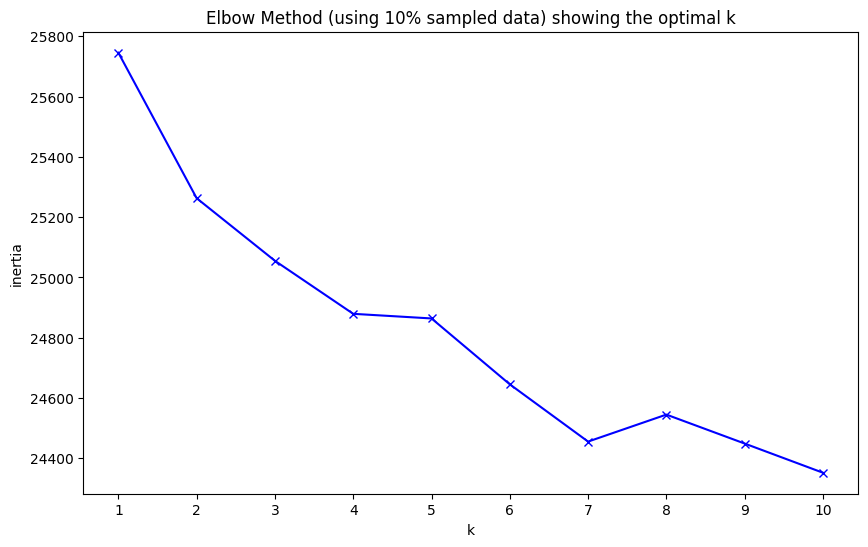

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk import punkt
from nltk.corpus import stopwords

K = range(1, 11)  # Define the range for K

# Randomly sample 10% of the data
sampled_data_10 = cleaned_data.sample(frac=0.1, random_state=1234)

# TF-IDF vectorization of the sampled preprocessed text
X_sampled_10 = tfidf_vectorizer.transform(sampled_data_10['post_text'])

# Computing inertia for different values of k (number of clusters) for the sampled data
inertia_sampled_10 = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_sampled_10)
    inertia_sampled_10.append(kmeans.inertia_)

# Plotting the Elbow Method for the 10% sampled data
plt.figure(figsize=(10, 6))
plt.plot(K, inertia_sampled_10, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K) + 1, 1.0))
plt.title('Elbow Method (using 10% sampled data) showing the optimal k')
plt.savefig("../../models/elbow_method.png")  
plt.show()

## Topic Modelling: Latent Dirichlet Allocation (LDA)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorizing the preprocessed text using Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_count = count_vectorizer.fit_transform(cleaned_data['post_text'])

# Number of topics to discover
num_topics = 10

# Training the LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=1234)
lda_model.fit(X_count)

# Function to display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topics.append(f"Topic {topic_idx}: {top_words}")
    return topics

# Displaying the top 10 words for each topic
top_words_per_topic = display_topics(lda_model, count_vectorizer.get_feature_names_out(), 10)
top_words_per_topic

['Topic 0: trump president maga election stopthesteal tomorrow america patriots freedom patriot',
 'Topic 1: history know story everyone kamala harris told civil please rights',
 'Topic 2: state votes election trump call president thank states pence right',
 'Topic 3: georgia votes county got warnock election fraud abrams biden dekalb',
 'Topic 4: dc patriots trump romney watch traitor flight echo police see',
 'Topic 5: dc going people trump president time us today take american',
 'Topic 6: trump echo follow name hidden votes senate biden pennsylvania maga',
 'Topic 7: trump election serremmy news video president pennsylvania thousand georgia votes',
 'Topic 8: god us like faith people name never government election win',
 'Topic 9: follow echo let county enough georgia ballots fulton court order']

### Topic Modelling Visualization

In [11]:
import pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Sampling 1% of the data for LDA topic modeling (to manage memory constraints)
sampled_data = cleaned_data.sample(frac=0.01, random_state=1234)

# Vectorizing the sampled data
X_count_sampled = count_vectorizer.transform(sampled_data['post_text'])

# Create a document-topic matrix for the sampled data
doc_topic_distr = lda_model.transform(X_count_sampled)

# Vocabulary and term frequency for the sampled data
vocab = count_vectorizer.get_feature_names_out()
term_frequency = X_count_sampled.sum(axis=0).tolist()[0]

# Prepare the data for pyLDAvis visualization
pyLDAvis_data = pyLDAvis.prepare(
    topic_term_dists=lda_model.components_, 
    doc_topic_dists=doc_topic_distr, 
    doc_lengths=sampled_data['post_text'].apply(len).values, 
    vocab=vocab, 
    term_frequency=term_frequency
)

# Display the interactive plot (in a Jupyter Notebook)
pyLDAvis.display(pyLDAvis_data)

# Save the visualization to an HTML file
pyLDAvis.save_html(pyLDAvis_data, '../../models/lda_visualization2.html')

## Time Series Analysis

### Hashtags

In [12]:
# Converting the post_timestamp into an actual date format
cleaned_data['date'] = pd.to_datetime('2021-01-09') - pd.to_timedelta(cleaned_data['post_timestamp'], unit='D')

# Displaying the first few rows to verify the date conversion
cleaned_data[['post_timestamp', 'date']].head()

,post_timestamp,date
0,5,2021-01-04
1,4,2021-01-05
2,5,2021-01-04
3,5,2021-01-04
4,5,2021-01-04


In [13]:
# Extracting hashtags considering both patterns (with and without space after "#")
cleaned_data['hashtags'] = cleaned_data['post_text'].apply(lambda x: re.findall(r'#\S+|#\s+\S+', str(x)))

# Replacing '# ' with '#' in the extracted hashtags
cleaned_data['hashtags'] = cleaned_data['hashtags'].apply(lambda x: [hashtag.replace('# ', '#') for hashtag in x])

# Displaying the first few rows to verify the updated hashtag extraction
cleaned_data[['post_text', 'hashtags']].head()

,post_text,hashtags
0,philadelphia police charged relation # antifa ...,[#antifa]
1,,[]
2,patriots dc ready tomorrow,[]
3,let follow,[]
4,,[]


In [14]:
from collections import Counter

# Function to find the top 5 hashtags for a given list of hashtags
def top_hashtags(hashtags_list):
    all_hashtags = [hashtag for hashtags in hashtags_list for hashtag in hashtags]
    return Counter(all_hashtags).most_common(5)

# Resampling the data by month and finding the top 5 hashtags for each month
monthly_trending_hashtags = cleaned_data.groupby(pd.Grouper(key='date', freq='M'))['hashtags'].apply(top_hashtags)

# Filtering to include only the months from July 2020 to January 2021
monthly_trending_hashtags = monthly_trending_hashtags['2020-07':'2021-01']

# Displaying the top 5 trending hashtags for each month
monthly_trending_hashtags

date
2020-07-31    [(#trump, 10), (#maga, 9), (#obamagate, 5), (#...
2020-08-31    [(#billclintonisapedo, 249), (#gijoevets, 51),...
2020-09-30    [(#americanpatriotnetwork, 51), (#cocass, 15),...
2020-10-31    [(#killary, 50), (#artimitateslife, 41), (#ikn...
2020-11-30    [(#riggedelection, 82), (#johnnybravo, 56), (#...
2020-12-31    [(#maga, 1399), (#trump, 1185), (#serremmy, 98...
2021-01-31    [(#stopthesteal, 10721), (#maga, 9707), (#trum...
Freq: M, Name: hashtags, dtype: object

In [15]:
# Printing the top 5 trending hashtags for each month
for month, top_hashtags in monthly_trending_hashtags.items():
    print(f"Month: {month.strftime('%B %Y')}")
    for hashtag, count in top_hashtags:
        print(f"  - {hashtag}: {count} occurrences")
    print()

Month: July 2020
  - #trump: 10 occurrences
  - #maga: 9 occurrences
  - #obamagate: 5 occurrences
  - #coronavirus: 4 occurrences
  - #treason: 4 occurrences

Month: August 2020
  - #billclintonisapedo: 249 occurrences
  - #gijoevets: 51 occurrences
  - #cocass: 34 occurrences
  - #tn: 34 occurrences
  - #trump: 23 occurrences

Month: September 2020
  - #americanpatriotnetwork: 51 occurrences
  - #cocass: 15 occurrences
  - #gijoevets: 15 occurrences
  - #tn: 15 occurrences
  - #co: 13 occurrences

Month: October 2020
  - #killary: 50 occurrences
  - #artimitateslife: 41 occurrences
  - #iknowithurts: 38 occurrences
  - #metoomyass: 36 occurrences
  - #truthisfreetonight: 29 occurrences

Month: November 2020
  - #riggedelection: 82 occurrences
  - #johnnybravo: 56 occurrences
  - #election: 40 occurrences
  - #trump: 30 occurrences
  - #artimitateslife: 25 occurrences

Month: December 2020
  - #maga: 1399 occurrences
  - #trump: 1185 occurrences
  - #serremmy: 981 occurrences
  - #sto

### LDA

In [16]:
def perform_lda(monthly_posts):
    # Vectorize the text
    X_count_monthly = count_vectorizer.transform(monthly_posts)

    # Apply the LDA model
    monthly_lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=1234)
    monthly_lda_model.fit(X_count_monthly)

    # Get the top words for each topic
    top_words_per_topic = display_topics(monthly_lda_model, count_vectorizer.get_feature_names_out(), 10)

    return top_words_per_topic

# Defining the specific range of months for analysis
months_to_analyze = pd.date_range(start='2020-07-01', end='2021-01-31', freq='MS')

# Repeating the LDA analysis for the specific monthly interval from July 2020 to January 2021
monthly_lda_topics_new = {}

# Filtering the data into the specific monthly intervals
for start_month, end_month in zip(months_to_analyze[:-1], months_to_analyze[1:]):
    monthly_posts = cleaned_data[(cleaned_data['date'] >= start_month) & (cleaned_data['date'] < end_month)]['post_text']
    if not monthly_posts.empty:  # Check if there are posts for this month
        monthly_lda_topics_new[end_month.strftime('%B %Y')] = perform_lda(monthly_posts)
    else:
        monthly_lda_topics_new[end_month.strftime('%B %Y')] = ["No posts for this month"]

# Displaying the main topics for the months
monthly_lda_topics_new

{'August 2020': ['Topic 0: trump would shame right democrats everyone spend back lot child',
  'Topic 1: biden joe arrested three times echo america time sick brother',
  'Topic 2: keep trump know country maga healthy time let life hero',
  'Topic 3: links let leave sink want get echo share twitter post',
  'Topic 4: photo officer corona texas mayor please everyone hope california davis',
  'Topic 5: white good know today video tired boy shit beat seeing',
  'Topic 6: never please maga tear spread video echo wwg wga share',
  'Topic 7: trump president echo support still years lives matter many three',
  'Topic 8: blocking picture echo bush free want speech needs america parler',
  'Topic 9: every get going media echo one support american president day'],
 'September 2020': ['Topic 0: trump patriots draintheswamp president us qanon maga stand man echo',
  'Topic 1: please echo federal find woman officers let speak everyone joined',
  'Topic 2: gijoevets cocass tn sex pedophilia slave in